<a href="https://colab.research.google.com/github/ShoSato-047/R_review/blob/main/STAT380_1_3_(2025)_Review_of_MLR_custom_contrasts_with_emmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is a contrast?

Often we are interested in using a fitted MLR model to estimate differences in the response for different combinations of the $X$ terms. These linear combinations are called *contrasts*.  In this notebook we explore how to conduct contrasts from a fitted MLR model.


# Case study: neurological impacts of lead exposure
*	We will continue to investigate the lead exposure data from the previous notebook:

In [1]:
library(dplyr)
lead <- read.csv('https://www.dropbox.com/s/r84evk7q5nciv94/LEAD.csv?dl=1')  %>%
  select(maxfwt, ageyrs, clumsi, Group,sex) %>%
  filter(!is.na(maxfwt))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
summary(lead)

     maxfwt          ageyrs         clumsi             Group          
 Min.   :13.00   Min.   : 5.08   Length:99          Length:99         
 1st Qu.:46.00   1st Qu.: 7.21   Class :character   Class :character  
 Median :52.00   Median : 9.67   Mode  :character   Mode  :character  
 Mean   :51.96   Mean   :10.07                                        
 3rd Qu.:59.00   3rd Qu.:12.75                                        
 Max.   :84.00   Max.   :15.92                                        
     sex           
 Length:99         
 Class :character  
 Mode  :character  
                   
                   
                   

Recall the following relationship:

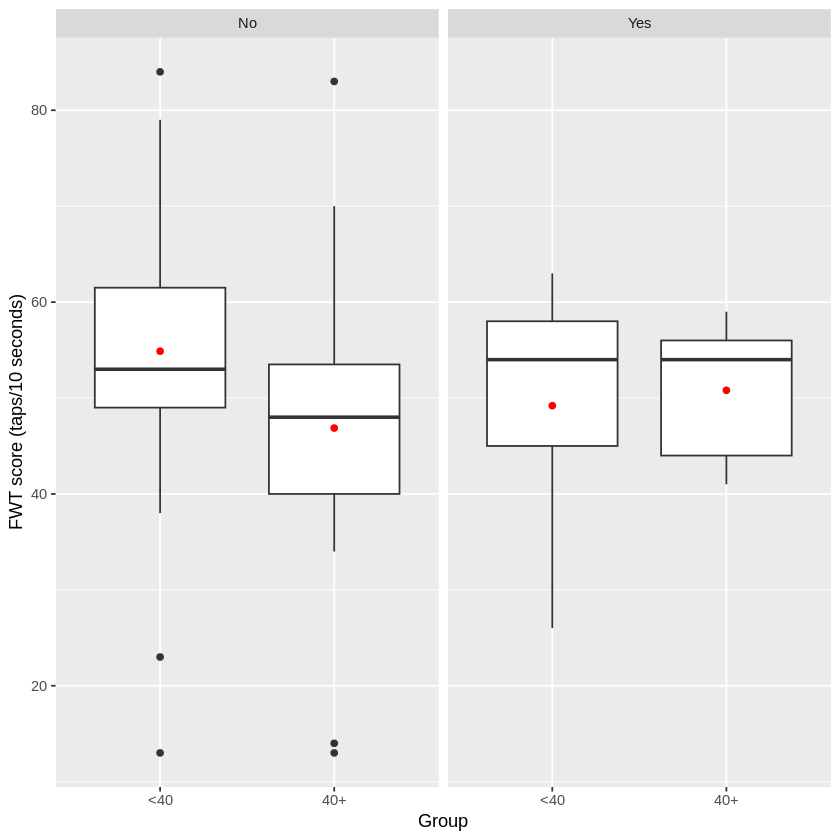

In [3]:
library(ggplot2)
ggplot(data = lead,aes(x = Group, y = maxfwt)) +
  geom_boxplot() +
  stat_summary(fun='mean', col='red',geom='point') +
    ylab('FWT score (taps/10 seconds)') +
    facet_wrap(~clumsi)

## The MLR model with interaction

Recall we had fit the following model:
$$E(Y|X_1,X_2) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1\cdot X_2$$

* $X_1 = \begin{cases}1; & \mbox{lead exposure} \geq 40 \\
0; & \mbox{lead exposure} < 40 \end{cases}$


* $X_2 = \begin{cases}1; & \mbox{clumsy}  \\
0; & \mbox{not clumsy} \end{cases}$

Fitting the model in R:

In [4]:
group_clumsi_fit <- lm(maxfwt~Group + clumsi+Group*clumsi, data = lead)
summary(group_clumsi_fit)


Call:
lm(formula = maxfwt ~ Group + clumsi + Group * clumsi, data = lead)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.881  -6.341   1.119   7.119  36.133 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          54.881      1.626  33.743  < 2e-16 ***
Group40+             -8.015      2.801  -2.861  0.00519 ** 
clumsiYes            -5.681      5.819  -0.976  0.33137    
Group40+:clumsiYes    9.615      8.383   1.147  0.25430    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.49 on 95 degrees of freedom
Multiple R-squared:  0.08212,	Adjusted R-squared:  0.05314 
F-statistic: 2.833 on 3 and 95 DF,  p-value: 0.04238


## Motivating `emmeans`

Suppose we want to test whether there is evidence for a significant difference in mean FWT score between the exposure groups, ***among clumsy children.***

This involves testing:

$$H_0: \beta_1 + \beta_3 = 0$$
$$H_0: \beta_1 + \beta_3 \ne 0$$

* The `summary(model)` output shows us limited information about differences between groups.
* If we want to test more nuanced contrasts, such as the impact of lead exposure among clumsy children, we need to set up the means themselves.

# Returning means and robust SE with `emmeans`

* The `emmeans` package is an extremely useful package for obtaining **E**stimated **M**arginal **Means**, and facilitating contrasts between them
* We can also use robust, heteroskedastic sandwich SE estimates = huge bonus!! (Do have to have the `sandwich` package loaded first.)

In [5]:
install.packages('sandwich')
library(sandwich)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’




In [6]:
install.packages('emmeans')
library(emmeans)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘estimability’, ‘numDeriv’, ‘mvtnorm’


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



Some important arguments:

* A model fit object
* `specs`; the variables for which you want means calculated.  A right-sided formula.  Required. If an interaction is specified in the model it does *not* need to be re-specified; imagine this more like specifying the grouping variables in `dplyr`.
* `vcov.`; either a covariance matrix or a function call to create a covariance matrix.  


Before we dive into `emmeans` though let's actually find grouped average and standard deviation of `maxfwt` scores using `dplyr`.

In [7]:
lead %>%
  group_by(Group, clumsi) %>%
  summarize(avg.maxfwt = mean(maxfwt, na.rm=TRUE), sd.maxfwt = sd(maxfwt, na.rm=TRUE), sampsize =  n())

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


Group,clumsi,avg.maxfwt,sd.maxfwt,sampsize
<chr>,<chr>,<dbl>,<dbl>,<int>
40+,No,46.86667,13.860719,30
40+,Yes,50.80000,7.854935,5
<40,No,54.88136,11.862844,59
<40,Yes,49.20000,14.549914,5


**QUESTION:** what does this output suggest regarding whether the "constant variance" assumption is satisfied?

In [8]:
# Does not appear to satisfied, note that 7.85 is about half as big as 14.55

Averaging across clumsiness levels:

In [9]:
lead %>%
  group_by(Group) %>%
  summarize(avg.maxfwt = mean(maxfwt, na.rm=TRUE), sampsize =  n())

Group,avg.maxfwt,sampsize
<chr>,<dbl>,<int>
40+,47.42857,35
<40,54.43750,64


Now let's create the emmeans from the model, using `vcovHC` so as to use robust standard error estimates.


In [10]:
group_clumsi_emmobj <- emmeans(group_clumsi_fit, specs = ~ Group + clumsi, vcov. = vcovHC) # vovHC = allows different standard erros (non-constant)
group_clumsi_emmobj

 Group clumsi emmean   SE df lower.CL upper.CL
 <40   No       54.9 1.56 95     51.8     58.0
 40+   No       46.9 2.57 95     41.8     52.0
 <40   Yes      49.2 7.27 95     34.8     63.6
 40+   Yes      50.8 3.93 95     43.0     58.6

Confidence level used: 0.95 

In [11]:
(54.9 + 49.2)/2

[1] 52.05

In [12]:
(46.9 + 50.8)/2

[1] 48.85

In [13]:
# When you average the average, you have to weight the smpale size!!!
# emmeans does NOT weight the sample size
?emmeans

Note how this differs if we change the specs:

In [14]:
emmeans(group_clumsi_fit, specs = ~ Group, vcov. = vcovHC)

NOTE: Results may be misleading due to involvement in interactions



 Group emmean   SE df lower.CL upper.CL
 <40     52.0 3.72 95     44.7     59.4
 40+     48.8 2.35 95     44.2     53.5

Results are averaged over the levels of: clumsi 
Confidence level used: 0.95 

Recall the summaries we obtained earlier:

In [15]:
#Averaging across group only:
lead %>%
  group_by(Group) %>%
  summarize(avg.maxfwt = mean(maxfwt, na.rm=TRUE), sampsize =  n())

Group,avg.maxfwt,sampsize
<chr>,<dbl>,<int>
40+,47.42857,35
<40,54.43750,64


In [16]:
#Averaging across both group and clumsiness status:
lead %>%
  group_by(Group, clumsi) %>%
  summarize(avg.maxfwt = mean(maxfwt, na.rm=TRUE), sampsize =  n())

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


Group,clumsi,avg.maxfwt,sampsize
<chr>,<chr>,<dbl>,<int>
40+,No,46.86667,30
40+,Yes,50.80000,5
<40,No,54.88136,59
<40,Yes,49.20000,5


**Question**:

* How do the estimated marginal means from `emmeans()` compare to these summaries?
* Why are they different, and how *are* these being calculated?

By defaults, `weights = 'equal'`. ***Only appropriate if sample sizes are the same!!***  To appropriately account for the differences in sample sizes we should set `weights = 'cells'` when averaging across another grouping variable.


In [17]:
(emobj <- emmeans(group_clumsi_fit, specs = ~ Group, vcov. = vcovHC, weights = 'cells'))

NOTE: Results may be misleading due to involvement in interactions



 Group emmean   SE df lower.CL upper.CL
 <40     54.4 1.54 95     51.4     57.5
 40+     47.4 2.28 95     42.9     51.9

Results are averaged over the levels of: clumsi 
Confidence level used: 0.95 

In [18]:
summary(emobj)

,Group,emmean,SE,df,lower.CL,upper.CL
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,<40,54.43750,1.544362,95,51.37155,57.50345
2,40+,47.42857,2.276402,95,42.90934,51.94780


***I cannot think of a reason you would ever want to use `weights='equal'`; always use `weights='cells'` if another factor variable is involved and you want to average over that factor to accurate group-specific averages.***

We can use the `at=` command to specify for which values of `clumsi` we want `Group` means calculated.  This is especially useful for looking at means when you have models involving a quantitative variable (more later):

In [19]:
emmeans(group_clumsi_fit, specs = ~ Group, vcov. = vcovHC, at = list(clumsi = c('No')))

NOTE: Results may be misleading due to involvement in interactions



 Group emmean   SE df lower.CL upper.CL
 <40     54.9 1.56 95     51.8       58
 40+     46.9 2.57 95     41.8       52

Confidence level used: 0.95 

In [20]:
emmeans(group_clumsi_fit, specs = ~ Group, vcov. = vcovHC, at = list(clumsi = c('Yes')))

NOTE: Results may be misleading due to involvement in interactions



 Group emmean   SE df lower.CL upper.CL
 <40     49.2 7.27 95     34.8     63.6
 40+     50.8 3.93 95     43.0     58.6

Confidence level used: 0.95 

In [21]:
emmeans(group_clumsi_fit, specs = ~ Group | vcov. = vcovHC)

ERROR: Error in parse(text = input): <text>:1:51: unexpected '='
1: emmeans(group_clumsi_fit, specs = ~ Group | vcov. =
                                                      ^


# Testing linear combinations

Consider the following:

1. Does average FWT score differ by exposure group, among children who are not clumsy?
2. Does average FWT score differ by exposure group, among children who are clumsy?

In terms of the `emmeans()` output:

In [ ]:
group_clumsi_emmobj

* We are testing:

1. $H_0: \mu_1 - \mu_2 = 0$
2. $H_0: \mu_3 - \mu_4 = 0$

* Each of these are *linear combinations* of the four means.  

* Linear combinations are of the form:

$$c_1 \mu_1 + c_2 \mu_2 + ... + c_k \mu_k$$

* Often, many of the $c_i = 0$ (if those means do not play a part in the question of interest)

## Write out the $c_i$

* Does average max FWT score differ by exposure group, among children who are not clumsy?
  - (1, -1, 0, 0)
* Does average max FWT score differ by exposure group, among children who are clumsy?
  - (0, 0, 1, -1)

## The `contrast()` function in `emmeans`

After creating an object with `emmeans()` we can specify contrasts using the `contrast()` function:

In [ ]:
group_clumsi_emmobj

Let's just show off some of the built-in contrasts; note that many of them come with default adjustments for multiple comparisons (can change with the `adjust=`) option:

In [ ]:
#Default method = 'eff', constrasting each mean to the "mean of the means":
contrast(group_clumsi_emmobj)

In [ ]:
#All pairwise comparisons; Tukey adjustment used automatically
contrast(group_clumsi_emmobj, method = 'pairwise')

We can specify our own contrasts with a list of vectors:

In [ ]:
#Customized contrast:
contrast(group_clumsi_emmobj, method=list('Lead exposure diff: not clumsy' = c(1,-1,0,0),
                                          'Lead exposure diff: clumsy' = c(0,0,1,-1)))

In [ ]:
#With a Bonferonni correction:
contrast(group_clumsi_emmobj, method=list('Lead exposure diff: not clumsy' = c(1,-1,0,0),
                                          'Lead exposure diff: clumsy' = c(0,0,1,-1)),
                                          adjust = 'Bonferroni')

**The Bonferroni correction is a statistical adjustment used to counteract the problem of multiple comparisons. It is applied when conducting multiple hypothesis tests simultaneously to reduce the likelihood of obtaining false-positive results (Type I errors).**

When multiple statistical tests are performed, the probability of making at least one Type I error increases with the number of tests. If you conduct 10 independent tests, the probability of making at least one false-positive result becomes

1−(1−0.05)^10 ≈ 0.40 ≈ 0.40, or 40%.

The Bonferroni correction adjusts for this by making the criteria for significance stricter. Specifically, it divides the overall significance level (α) by the number of tests (n) being performed.For example, if you are performing 10 tests with an overall 𝛼 = 0.05, the Bonferroni-corrected significance level for each individual test is:

𝛼_adjusted = 0.05 / 10 = 0.005

Alternatively, we can perform `pairwise` comparisons for each level of `clumsi`:

In [ ]:
(clumsi_contrasts <- contrast(group_clumsi_emmobj, method='pairwise', by = 'clumsi'))

We can extract the contrast coefficients being used and compare them to the ones we input manually:

In [ ]:
coef(clumsi_contrasts)

Another approach is to redefine the formula in the `emmeans()` step, so that `clumsi` is already considered a higher-order grouping variable:

In [ ]:
group_clumsi_emobj2 <- emmeans(group_clumsi_fit, ~Group|clumsi, vcov.=vcovHC)
group_clumsi_emobj2

Then we use pairwise contrasts, which will be performed at the level of the higher-order grouping variable:

In [ ]:
contrast(group_clumsi_emobj2, method='pairwise')

Confidence intervals for contrasts can be obtained using the `confint()` function:

In [ ]:
get_contrasts <- contrast(group_clumsi_emobj2, method='pairwise')
confint(get_contrasts)

In [ ]:
## Doing a big ol' pipe for everything

(group_clumsi_fit
  %>% emmeans(specs = ~Group|clumsi, vcov.=vcovHC)
  #%>% contrast(method='pairwise', adjust='Bonferroni', by = 'clumsi')
  %>% contrast(method=list('Lead exposure diff: not clumsy' = c(1,-1,0,0),
                                          'Lead exposure diff: clumsy' = c(0,0,1,-1)),
                                          adjust = 'Bonferroni')
 # %>% confint()
)

In [28]:
# big pipe
# 2 ways to get the same result

(
  group_clumsi_fit
    %>% emmeans(specs = ~Group|clumsi, vcov.=vcovHC)
    %>% contrast(method = 'pairwise')
    #%>% contrast(method = list(c(0,0,1,-1)))
    %>% confint
)

,contrast,clumsi,estimate,SE,df,lower.CL,upper.CL
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,<40 - (40+),No,8.014689,3.008511,95,2.042039,13.98734
2,<40 - (40+),Yes,-1.600000,8.267406,95,-18.012876,14.81288


In [ ]:
# characterize the contrast . . . read below

## Conclusion summary (take note for HW assignments)

* Among non-clumsy children,  the average FWT was 8 taps/10s higher in the low exposure group than in the high exposure group.  This is a statistically significant difference in the average FWT score comparing children with high and low lead exposures (p-value = 0.009; 95% CI: 2, 14)

* Among clumsy children, the average FWT score was 1.6 taps/10s lower in the low exposure group than in the high exposure group.  There is no evidence of a statistically significant difference in the average FWT score comparing children with high and low lead exposures (p-value = 0.847; 95% CI: -18, 15).




# Interactions with a quantitative covariate

* AKA "Analysis of Covariance" (ANCOVA)
* Consider the following model:

$$E(Y|X_1, X_2) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3 X_1X_2$$  

where:


* $X_1 = \begin{cases}1; & \mbox{lead exposure} \geq 40 \\
0; & \mbox{lead exposure} < 40 \end{cases}$
* $X_2$ = Age (in years)


`geom_smooth()` using formula = 'y ~ x'


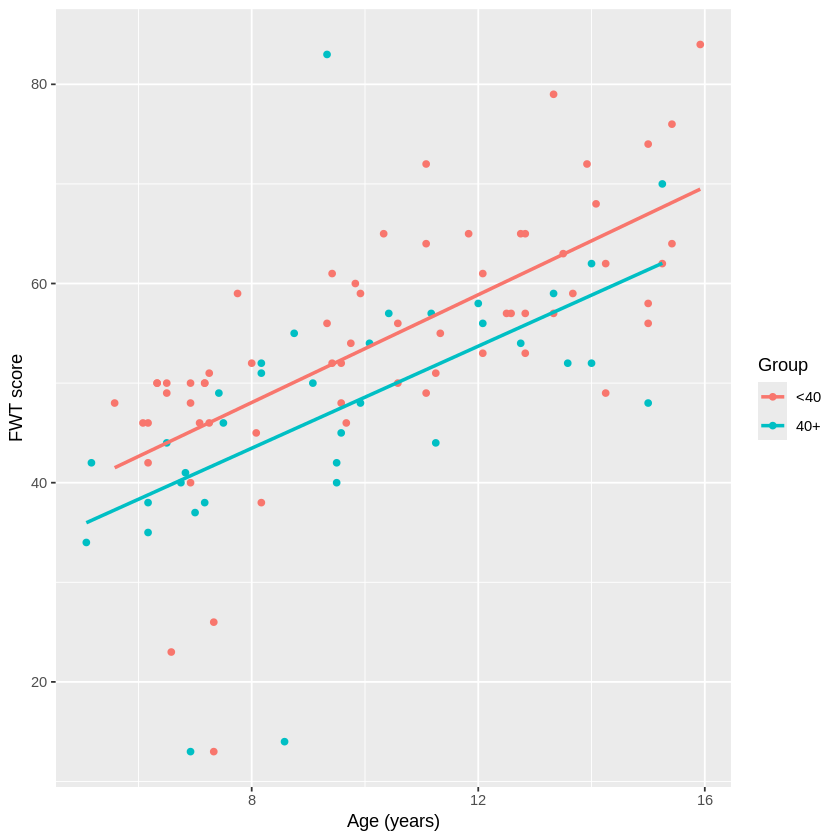

In [29]:
library(ggplot2)
ggplot(data = lead, aes(x = ageyrs, y = maxfwt, color=Group)) +
  geom_point(aes(color=Group)) +
  stat_smooth(method='lm', se = FALSE) +
    xlab('Age (years)') + ylab('FWT score')

Fitting this model:

In [30]:
grp.age.fit <- lm(maxfwt~Group + ageyrs + Group*ageyrs, data = lead)
summary(grp.age.fit)


Call:
lm(formula = maxfwt ~ Group + ageyrs + Group * ageyrs, data = lead)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.241  -4.360   0.967   5.584  36.129 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      26.4109     4.2667   6.190 1.52e-08 ***
Group40+         -3.4423     7.1380  -0.482    0.631    
ageyrs            2.7053     0.3951   6.848 7.38e-10 ***
Group40+:ageyrs  -0.1434     0.6972  -0.206    0.837    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.643 on 95 degrees of freedom
Multiple R-squared:  0.4532,	Adjusted R-squared:  0.4359 
F-statistic: 26.24 on 3 and 95 DF,  p-value: 1.887e-12


Assessing model assumptions:

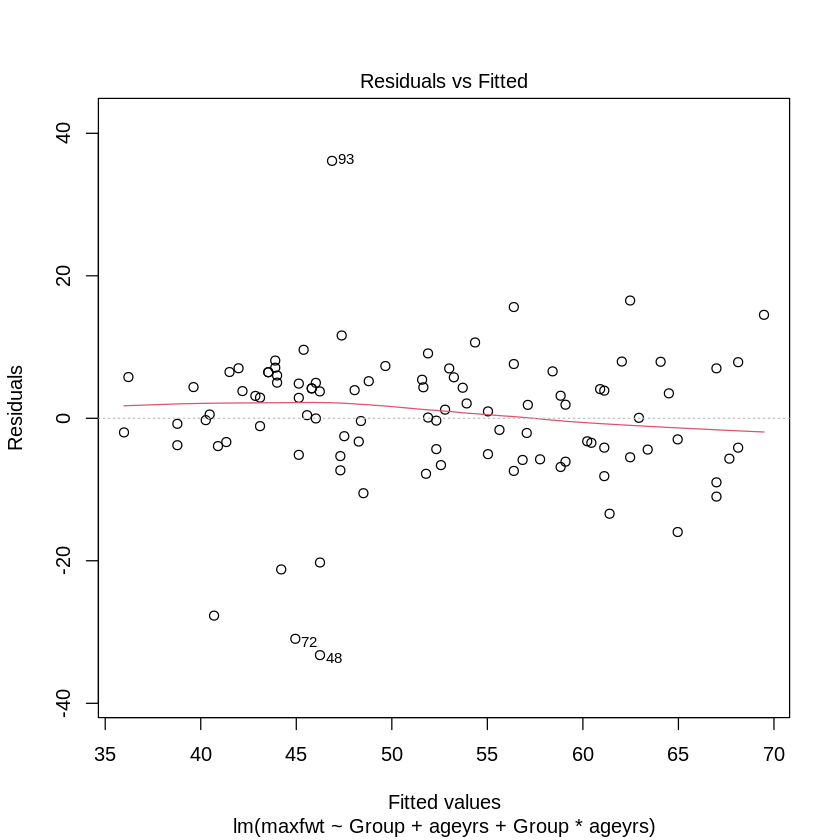

In [31]:
plot(grp.age.fit, which = 1)

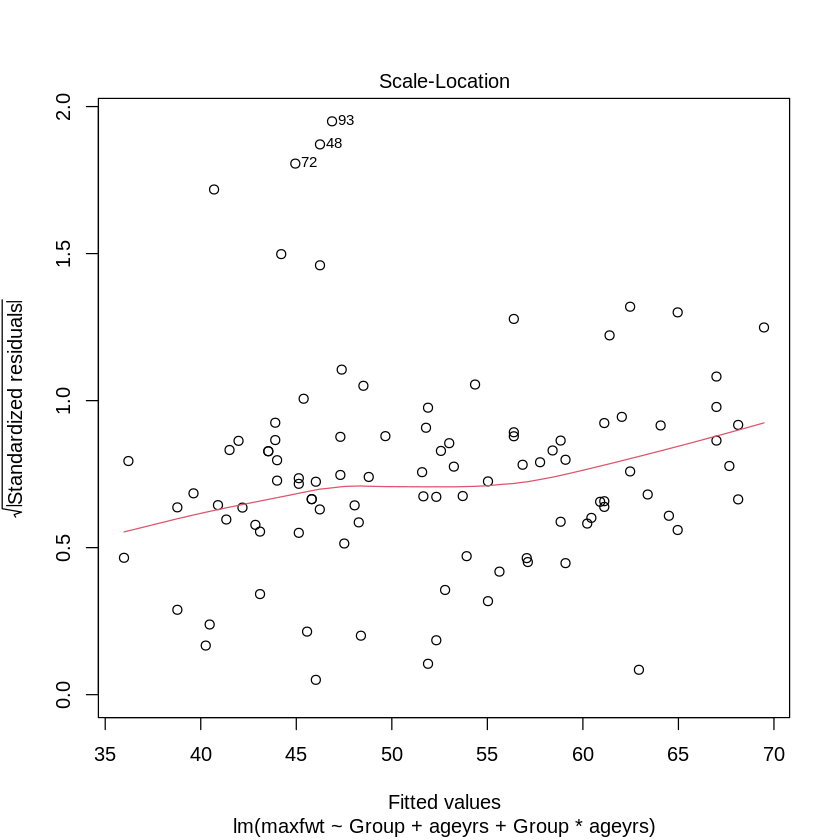

In [32]:
plot(grp.age.fit, which = 3)

* What do these plots suggest regarding assumption satisfaction?

In [ ]:
# Fit quality looks okay: first plot, the smooth is relatively flat.
# Constant variance: issues. Meagphone in 1st plot, on-flat trend in the scale-location plot.

## Testing for interaction

From this output, there is no evidence to suggest that the difference of max FWT score across lead exposure groups is different at various ages (robust p-value = 0.8268).

Another way of looking at it: there is no evidence that the association of max FWT with age differs in the two exposure groups.


## Testing linear combinations (quantitative covariate)

Consider testing the following with this model:

*  What is the difference in average  FWT between lead exposure groups, for 8-year-old children?
*  What is the difference in average  FWT between lead exposure groups, for 10-year-old children?
* What is the difference in average FWT between 8- and 10-year old children, for the low exposure group?
* What is the difference in average FWT between 8- and 10-year old children, for the high exposure group?

Note that since `ageyrs` is quantitative we must specify specific values of this variable or it will model lead group means at the average age (10.1 years) by default:

In [33]:
# at: specifies when you see the contrast at
# You want to see the contrast at age 8 and 10
(grpmeans.byage <- emmeans(grp.age.fit, specs = ~Group|ageyrs, vcov. = vcovHC, at = list(ageyrs = c(8,10))))

ageyrs =  8:
 Group emmean   SE df lower.CL upper.CL
 <40     48.1 1.56 95     45.0     51.1
 40+     43.5 2.19 95     39.1     47.8

ageyrs = 10:
 Group emmean   SE df lower.CL upper.CL
 <40     53.5 1.15 95     51.2     55.7
 40+     48.6 1.87 95     44.9     52.3

Confidence level used: 0.95 

In [34]:
(agemeans.bygrp <- emmeans(grp.age.fit, specs = ~ageyrs|Group, vcov. = vcovHC, at = list(ageyrs = c(8,10))))

Group = <40:
 ageyrs emmean   SE df lower.CL upper.CL
      8   48.1 1.56 95     45.0     51.1
     10   53.5 1.15 95     51.2     55.7

Group = 40+:
 ageyrs emmean   SE df lower.CL upper.CL
      8   43.5 2.19 95     39.1     47.8
     10   48.6 1.87 95     44.9     52.3

Confidence level used: 0.95 

In [35]:
contrast(grpmeans.byage, method='pairwise')

ageyrs =  8:
 contrast    estimate   SE df t.ratio p.value
 <40 - (40+)     4.59 2.69 95   1.705  0.0915

ageyrs = 10:
 contrast    estimate   SE df t.ratio p.value
 <40 - (40+)     4.88 2.20 95   2.219  0.0289


In [36]:
contrast(agemeans.bygrp,method='pairwise')

Group = <40:
 contrast           estimate    SE df t.ratio p.value
 ageyrs8 - ageyrs10    -5.41 0.789 95  -6.853  <.0001

Group = 40+:
 contrast           estimate    SE df t.ratio p.value
 ageyrs8 - ageyrs10    -5.12 1.040 95  -4.918  <.0001


Note:

* The lead exposure difference is very similar for 8- and 10-year olds, consistent with a lack of interaction (and our visual from the scatterplot).  However:
  - The exposure difference is significant for the 10-year-olds (p-value = 0.0193) but not the 8-year-olds (p-value = 0.0591).
* Similarly, the age difference is quite similar for the high- and low-exposure groups, and is highly significant for both (both p-values < .0001).

## When there is no significant interaction...

Here, the Group*Age interaction is not statistically significant, and visually it does not appear that the Lead Exposure Group difference is influenced much by Age.  We could consider fitting a simplified model that just adjusts for age, aka the "parallel line" model:

In [38]:
# no interaction (parallel model) is better
AIC(grp.age.fit, grp.age.parallel.fit)

,df,AIC
,<dbl>,<dbl>
grp.age.fit,5,735.5768
grp.age.parallel.fit,4,733.6209


In [37]:
grp.age.parallel.fit <- lm(maxfwt~Group + ageyrs, data = lead)
summary(grp.age.parallel.fit)


Call:
lm(formula = maxfwt ~ Group + ageyrs, data = lead)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.380  -4.301   0.977   5.495  36.150 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  26.8878     3.5635   7.545 2.57e-11 ***
Group40+     -4.8489     2.0342  -2.384   0.0191 *  
ageyrs        2.6592     0.3239   8.210 1.02e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.595 on 96 degrees of freedom
Multiple R-squared:  0.4529,	Adjusted R-squared:  0.4415 
F-statistic: 39.74 on 2 and 96 DF,  p-value: 2.669e-13


Unfortunately there's no easy way to force parallel lines with `geom_smooth()` in `ggplot`; we have to add fitted values to the data set and draw them:

In [39]:
lead$parallel.fitted.values <- fitted(grp.age.parallel.fit)

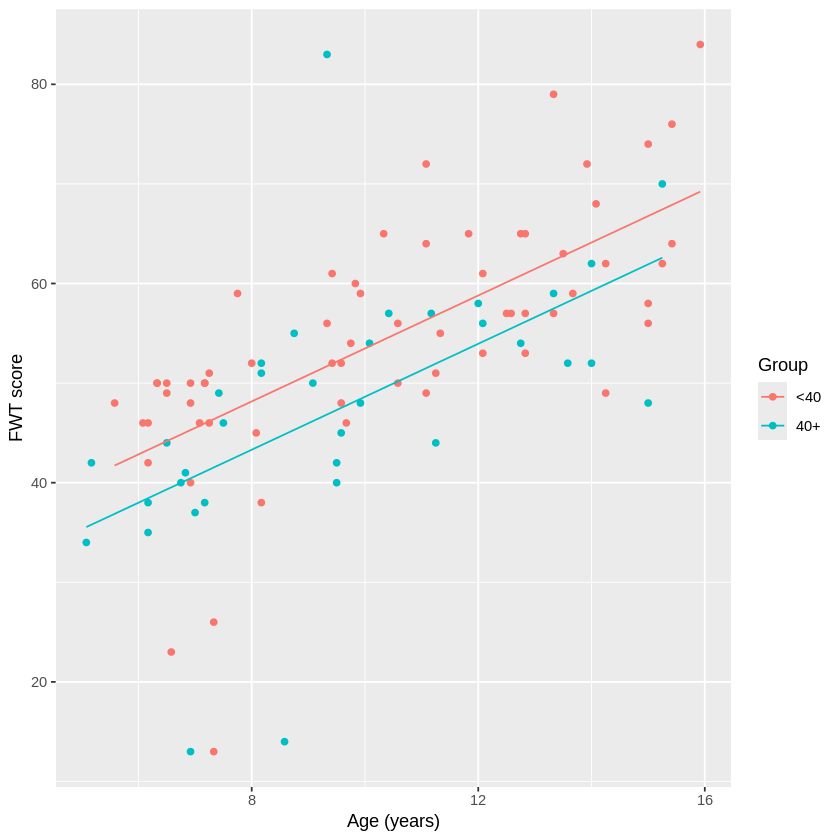

In [40]:

ggplot(data = lead, aes(x = ageyrs, y = maxfwt, color=Group)) +
  geom_point(aes(y = maxfwt)) +
  geom_line(aes(y = parallel.fitted.values)) +
    xlab('Age (years)') + ylab('FWT score')


Using `emmean()` to return the fitted values of each line:

In [41]:
# The difference between finger tapping score at average age: 53.7 and 48.8
(grp.age.adjusted.means <- emmeans(grp.age.parallel.fit, ~Group, vcov. = vcovHC))

 Group emmean   SE df lower.CL upper.CL
 <40     53.7 1.13 96     51.4     55.9
 40+     48.8 1.87 96     45.1     52.5

Confidence level used: 0.95 

By default, these are calculated at the average age.  Can you verify these marginal means from the fitted model output?

In [42]:
mean(lead$ageyrs)

[1] 10.07283

In [43]:
26.8878 + 2.6592*10.0728282

[1] 53.67346

In [44]:
26.8878 + 2.6592*10.0728282 - 4.8489

[1] 48.82456

We can then use `contrast()` to compare these means.  Because the lines are parallel, it doesn't matter whether we contrast the <40 to 40+ at the mean age, or any other age; the contrasts will be the same since the vertical distance between the two lines is constant.

In [45]:
contrast(grp.age.adjusted.means, 'pairwise')

 contrast    estimate   SE df t.ratio p.value
 <40 - (40+)     4.85 2.19 96   2.212  0.0294


**Questions**

* How does this contrast compare to the 8- and 10- year specific contrasts from earlier?
* How would we interpret this contrast?

In [46]:
# Answer:
# It is very similar
# When comparing kids of the same age, those with high lead exposure have
# on average 4.85 taps less FWT score than those with low lead exposure.

In [47]:
# lets do this contrast for 8 year olds, with the parallel line model:
# We suppose to have the same contrast: 4.85 because of the model we are using.
(emmeans(grp.age.parallel.fit, specs = ~Group|ageyrs, at = list(ageyrs = c(8, 10)))
  %>% contrast(method='pairwise')
)

ageyrs =  8:
 contrast    estimate   SE df t.ratio p.value
 <40 - (40+)     4.85 2.03 96   2.384  0.0191

ageyrs = 10:
 contrast    estimate   SE df t.ratio p.value
 <40 - (40+)     4.85 2.03 96   2.384  0.0191


# Interaction + Adjustment

* No evidence for interaction of group with age

* There *is* evidence for interaction of group with clumsiness

* May want to include a model that allows for Group\*Clumsiness interaction, *adjusting for* age and sex

## The model


$$E(Y|X_1, X_2,X_3,X_4) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3 X_1X_2 + \beta_4X_3 + \beta_5X_4$$  

where:


* $X_1 = \begin{cases}1; & \mbox{lead exposure} \geq 40 \\
0; & \mbox{lead exposure} < 40 \end{cases}$
* $X_2 = \begin{cases}1; & \mbox{clumsy}\\
0; & \mbox{not clumsy} \end{cases}$
* $X_3 = Age$
* $X_4 = \begin{cases}1; & \mbox{male}\\
0; & \mbox{female} \end{cases}$



Fitting this model:

In [48]:
bigmodel <- lm(maxfwt~Group*clumsi + ageyrs + sex, data = lead)
summary(bigmodel)


Call:
lm(formula = maxfwt ~ Group * clumsi + ageyrs + sex, data = lead)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.309  -4.345   0.928   5.975  35.682 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          25.998      4.039   6.436 5.28e-09 ***
Group40+             -5.423      2.177  -2.490   0.0145 *  
clumsiYes            -6.506      4.491  -1.449   0.1508    
ageyrs                2.716      0.332   8.180 1.43e-12 ***
sexM                  1.405      2.014   0.697   0.4874    
Group40+:clumsiYes    6.791      6.465   1.050   0.2963    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.606 on 93 degrees of freedom
Multiple R-squared:  0.4688,	Adjusted R-squared:  0.4402 
F-statistic: 16.41 on 5 and 93 DF,  p-value: 1.39e-11


Using this model, answer the following:

A. What is the difference in mean max FWT between exposure groups, among non-clumsy children of the same age and sex?  Also determine whether this difference is statistically significant.  

B. What is the difference in mean max FWT between exposure groups, between clumsy children of the same age and sex?  Also determine whether this difference is statistically significant.  

Things to consider:

* Variance assumption?
* Weights to use when averaging across adjustment factors?
